In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_loc = '/content/drive/MyDrive/Projects mentored/23-jan/output/output3/train'
test_loc = '/content/drive/MyDrive/Projects mentored/23-jan/output/output3/val'

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 5515 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [ ]:
diagnosis_csv = '/content/drive/MyDrive/Projects mentored/23-jan/output/output3/patient_diagnosis.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
categories = diagnosis['diagnosis'].unique()
categories

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [ ]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(8, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-20:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'block1_pool' is trainable
Layer 'block2_conv1' is trainable
Layer 'block2_conv2' is trainable
Layer 'block2_pool' is trainable
Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [ ]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy,
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1149.0,
 1: 55.373493975903614,
 2: 35.90625,
 3: 1.0,
 4: 17.883268482490273,
 5: 183.84,
 6: 20.157894736842106,
 7: 23.690721649484537}

In [ ]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata,
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size,
                 epochs=100,callbacks=[checkpoint,early])

Epoch 1/100
172/172 [==============================] - ETA: 0s - loss: 42.6013 - accuracy: 0.1413 - mae: 0.2099 
Epoch 1: val_accuracy improved from -inf to 0.01817, saving model to vgg16_base_res.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 2424s 14s/step - loss: 42.6013 - accuracy: 0.1413 - mae: 0.2099 - val_loss: 2.5885 - val_accuracy: 0.0182 - val_mae: 0.2266
Epoch 2/100
172/172 [==============================] - ETA: 0s - loss: 22.7823 - accuracy: 0.0976 - mae: 0.2142
Epoch 2: val_accuracy did not improve from 0.01817
172/172 [==============================] - 90s 520ms/step - loss: 22.7823 - accuracy: 0.0976 - mae: 0.2142 - val_loss: 2.2068 - val_accuracy: 0.0051 - val_mae: 0.2222
Epoch 3/100
172/172 [==============================] - ETA: 0s - loss: 14.6125 - accuracy: 0.0438 - mae: 0.2197
Epoch 3: val_accuracy improved from 0.01817 to 0.02326, saving model to vgg16_base_res.h5
172/172 [==============================] - 95s 549ms/step - loss: 14.6125 - accuracy: 0.0438 - mae: 0.2197 - val_loss: 2.1164 - val_accuracy: 0.0233 - val_mae: 0.2198
Epoch 4/100
172/172 [==============================] - ETA: 0s - loss: 14.5625 - accuracy: 0.0717 - mae: 0.2186
Epoch 4: val_accuracy 

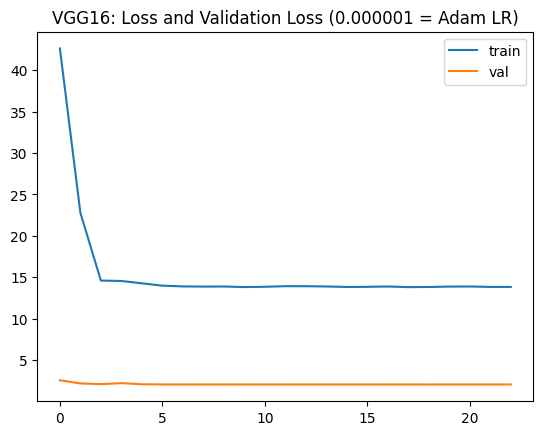

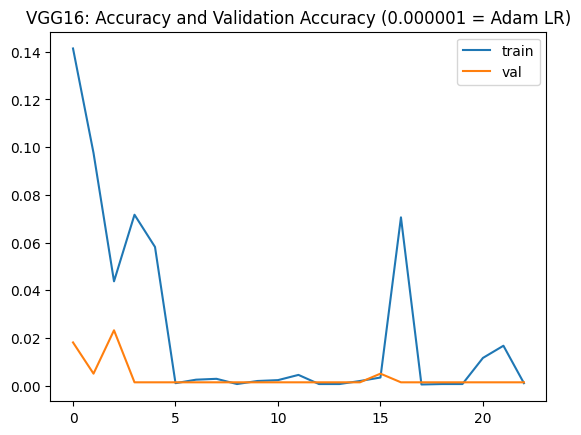

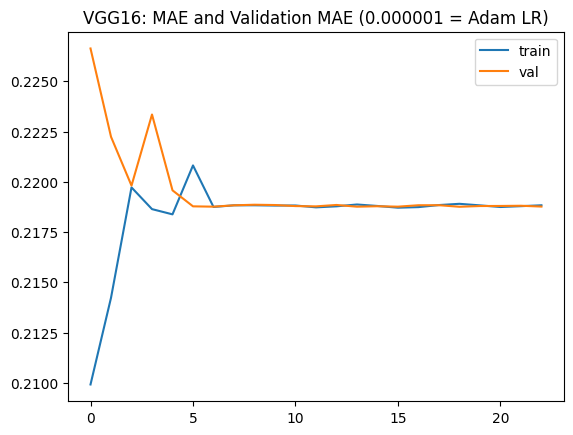

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('VGG16: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.show()

In [ ]:
model.evaluate(testdata)

44/44 [==============================] - 17s 376ms/step - loss: 2.0800 - accuracy: 0.0014 - mae: 0.2188


[2.079983949661255, 0.0014461316168308258, 0.2187669724225998]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# predict classes of validation dataset
val_predict = model.predict(testdata)

44/44 [==============================] - 16s 357ms/step


In [ ]:
import numpy as np


In [ ]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
labels = ['Asthma','Bronchiectasis','Bronchiolitis','COPD','Healthy','LRTI','Pneumonia','URTI']
report = classification_report(testdata.classes, predict_class, target_names=labels)
print(report)

                precision    recall  f1-score   support

        Asthma       0.00      1.00      0.00         2
Bronchiectasis       0.00      0.00      0.00        21
 Bronchiolitis       0.00      0.00      0.00        32
          COPD       0.00      0.00      0.00      1150
       Healthy       0.00      0.00      0.00        65
          LRTI       0.00      0.00      0.00         7
     Pneumonia       0.00      0.00      0.00        57
          URTI       0.00      0.00      0.00        49

      accuracy                           0.00      1383
     macro avg       0.00      0.12      0.00      1383
  weighted avg       0.00      0.00      0.00      1383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(testdata.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Bronchiectasis','Bronchiolitis','COPD','Healthy','LRTI','Pneumonia','URTI'],
                     columns = ['Asthma','Bronchiectasis','Bronchiolitis','COPD','Healthy','LRTI','Pneumonia','URTI'])

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()